In [76]:
# import packages
import pandas as pd
import numpy as np
import nltk
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.metrics as metrics
import gensim
import gensim.downloader as api
import joblib
from numpy import mean
from numpy import std
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import accuracy_score, classification_report
from sklearn.compose import ColumnTransformer
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB # multinomial suitable for discrete data and more powerful than bernoulli
from sklearn.preprocessing import Normalizer
from sentence_transformers import SentenceTransformer
from keras.models import Sequential, model_from_json
from keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint
from joblib import dump, load

In [3]:
# import depression detection csv
df = pd.read_csv (r'C://Users//lvlip//Documents//BCSI Sem 6//FYP 4202//CSV//depression_detection.csv', engine='python')
df.head()

,username,datetime,tweet,cleaned_tweet,target,tweet_compound,fear,anger,anticipation,trust,...,primarysupport,troubleconcentrate,worthlessness/guilt,housing,disturbedsleep,occupational,fatigue/lossenergy,weight/appetite,agitation/retardation,topic
0,robertevans97,16/12/21 14:27:14,@arielhelwani @DustinPoirier @NateDiaz209 Big ...,big fight dustin want prove point nate,normal,-0.3182,0.25,0.25,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
1,flintmorris,16/12/21 14:27:14,@ItsRyanGonzales @100Thieves @RabidDoh @thundo...,they choose one best naruto opening song big,normal,0.6369,0.00,0.00,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4
2,chardinite,16/12/21 14:27:14,@Tinkzorg Gen Z can't wield the mandate of hea...,gen z not wield mandate heaven confirm,normal,0.5106,0.00,0.00,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5
3,ghobubo,16/12/21 14:27:14,@JortsTheCat has his own account and 20K follo...,his account follower sweet potato,normal,0.4588,0.00,0.00,0.142857,0.428571,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7
4,mdarahimkhan2,16/12/21 14:27:14,@BitKeepOS @NEARProtocol This is a really grea...,really great excellent project thank you oppor...,normal,0.9604,0.00,0.00,0.250000,0.187500,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3


In [4]:
# select balance samples from each target group and shuffle the data
np.random.seed(1000)

normal_df = df[df['target']=='normal'].sample(5000)
depressed_df = df[df['target']=='depressed'].sample(5000)

df = pd.concat([normal_df, depressed_df]).sample(frac=1)
df = df.reset_index(drop=True)

df.shape

(10000, 30)

In [5]:
# extract x and y for train test split
x = df[df.columns.difference(['username', 'datetime', 'tweet', 'target'])]
y = df.target

In [6]:
# train test split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=.2, random_state=1000)

In [7]:
print("Train set has total {0} entries with {1:.2f}% depressed,\
      {2:.2f}% normal".format(len(x_train), (len(x_train[y_train=='depressed']) / (len(x_train)*1.))*100,
                              (len(x_train[y_train=='normal']) / (len(x_train)*1.))*100))

print("Test set has total {0} entries with {1:.2f}% depressed,\
        {2:.2f}% normal".format(len(x_test), (len(x_test[y_test=='depressed']) / (len(x_test)*1.))*100,
                                (len(x_test[y_test=='normal']) / (len(x_test)*1.))*100))

Train set has total 8000 entries with 50.18% depressed, 49.83% normal
Test set has total 2000 entries with 49.30% depressed, 50.70% normal


# Logistic Regression + TF-IDF + Trigram

In [8]:
# model with 'cleaned_text' only - logistic regression + tf-dif + trigram

# initialize vectorizer
tfidf = TfidfVectorizer(stop_words=None, ngram_range=(1, 3), max_features=150000)

# transform tf-idf
x_train_text = tfidf.fit_transform(x_train['cleaned_tweet'])
x_test_text = tfidf.transform(x_test['cleaned_tweet'])

# prepare the cross-validation procedure
cv = KFold(n_splits=10, random_state=1, shuffle=True)

np.random.seed(1000)

# fit the model
lr = LogisticRegression().fit(x_train_text, y_train)

In [12]:
# evaluate training model
training_score = cross_val_score(lr, x_train_text, y_train, scoring='accuracy', cv=cv)

# training report performance
print('training accuracy: %.3f (%.3f)' % (mean(training_score), std(training_score)))

# evaluate testing model
testing_score = cross_val_score(lr, x_test_text, y_test, scoring='accuracy', cv=cv)

# testing report performance
print('testing accuracy: %.3f (%.3f)' % (mean(testing_score), std(testing_score)))

training accuracy: 0.881 (0.015)
testing accuracy: 0.871 (0.023)


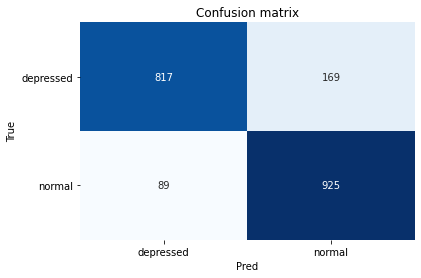

In [14]:
# plot confusion matrix
y_pred = cross_val_predict(lr, x_test_text, y_test, cv=cv)
cm = metrics.confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
            cbar=False)
ax.set(xlabel='Pred', ylabel='True', xticklabels=['depressed', 'normal'], 
       yticklabels=['depressed', 'normal'], title="Confusion matrix")
plt.yticks(rotation=0)
plt.show()

In [15]:
# model with other linguistic features - logistic regression + tf-dif + trigram

# initialize model and vectorizer
tfidf = TfidfVectorizer(stop_words=None, ngram_range=(1, 3), max_features=150000)
lr = LogisticRegression(max_iter=300)

# construct the column transfomer
column_transformer = ColumnTransformer(
    [('tfidf', tfidf, 'cleaned_tweet')],
    remainder='passthrough')

# transform tf-idf
column_transformer.fit_transform(x_train)
column_transformer.transform(x_test)

# fit the model
pipeline = Pipeline([
                  ('tfidf', column_transformer),
                  ('classifier', lr)
                ])

# prepare the cross-validation procedure
cv = KFold(n_splits=10, random_state=1, shuffle=True)

np.random.seed(1000)

pipeline_fit = pipeline.fit(x_train, y_train)

In [16]:
# evaluate training model
training_score = cross_val_score(pipeline_fit, x_train, y_train, scoring='accuracy', cv=cv)

# training report performance
print('training accuracy: %.3f (%.3f)' % (mean(training_score), std(training_score)))

# evaluate testing model
testing_score = cross_val_score(pipeline_fit, x_test, y_test, scoring='accuracy', cv=cv)

# testing report performance
print('testing accuracy: %.3f (%.3f)' % (mean(testing_score), std(testing_score)))

training accuracy: 0.905 (0.013)
testing accuracy: 0.887 (0.019)


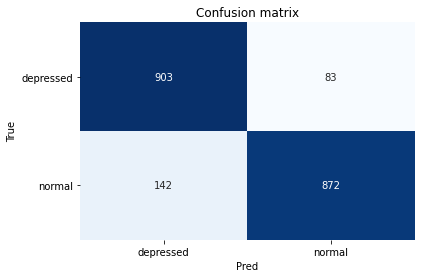

In [18]:
# plot confusion matrix
y_pred = cross_val_predict(pipeline_fit, x_test, y_test, cv=cv)
cm = metrics.confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
            cbar=False)
ax.set(xlabel='Pred', ylabel='True', xticklabels=['depressed', 'normal'], 
       yticklabels=['depressed', 'normal'], title="Confusion matrix")
plt.yticks(rotation=0)
plt.show()

# Compare Classifier - LR & RF & SVM

In [19]:
# make comparison with LR, RF, and SVM
names = ['Logistic Regression', 'Linear SVC (SVM)', 'Random Forest']
classifiers = [LogisticRegression(max_iter = 300), LinearSVC(max_iter = 2500), RandomForestClassifier()]
zipped_clf = zip(names, classifiers)

for n,c in zipped_clf:

    pipeline = Pipeline([
        ('tfidf', column_transformer),
        ('classifier', c)
    ])

    cv = KFold(n_splits=10, random_state=1, shuffle=True)
    
    np.random.seed(1000)
  
    pipeline_fit = pipeline.fit(x_train, y_train)

    print(c)

    training_score = cross_val_score(pipeline_fit, x_train, y_train, scoring='accuracy', cv=cv)
    print('training accuracy: %.3f (%.3f)' % (mean(training_score), std(training_score)))

    testing_score = cross_val_score(pipeline_fit, x_test, y_test, scoring='accuracy', cv=cv)
    print('testing accuracy: %.3f (%.3f)' % (mean(testing_score), std(testing_score)))

    # make prediction
    y_pred = cross_val_predict(pipeline_fit, x_test, y_test, cv=cv)
    print(classification_report(y_test, y_pred)) # SVM the highest

LogisticRegression(max_iter=300)
training accuracy: 0.905 (0.013)
testing accuracy: 0.887 (0.019)
              precision    recall  f1-score   support

   depressed       0.86      0.92      0.89       986
      normal       0.91      0.86      0.89      1014

    accuracy                           0.89      2000
   macro avg       0.89      0.89      0.89      2000
weighted avg       0.89      0.89      0.89      2000

LinearSVC(max_iter=2500)
training accuracy: 0.915 (0.012)
testing accuracy: 0.898 (0.015)
              precision    recall  f1-score   support

   depressed       0.87      0.94      0.90       986
      normal       0.93      0.86      0.90      1014

    accuracy                           0.90      2000
   macro avg       0.90      0.90      0.90      2000
weighted avg       0.90      0.90      0.90      2000

RandomForestClassifier()
training accuracy: 0.890 (0.016)
testing accuracy: 0.888 (0.026)
              precision    recall  f1-score   support

   depressed 

# Pretrained Google News Word2Vec & SVM

In [20]:
googlenews = api.load("word2vec-google-news-300")

In [21]:
# tokenize tweets
x_train_tokens = [word_tokenize(x) for x in x_train['cleaned_tweet']]
x_test_tokens = [word_tokenize(x) for x in x_test['cleaned_tweet']]

In [23]:
# to average all of the word vectors for a set of words
def make_feature_vec(words, model, num_features):
  
    count = 0

    vector = np.zeros((num_features, ), dtype = 'float32')  

    index2key_set = set(model.wv.index_to_key) # list that contains words in the model's vocabulary

    for word in words:
        if word in index2key_set: 
            count += 1
            vector = np.add(vector, model.wv[word])

    vector = np.divide(vector, count)
    return vector

# to calculate the average feature vector for each tweet and return a 2D numpy array 
def avg_feature_vecs(tweets, model, num_features):

    count = 0 
  
    vector = np.zeros((len(tweets), num_features), dtype = 'float32') # initialization for speed

    for tweet in tweets:
        vector[count] = make_feature_vec(tweet, model, num_features)
        count += 1
    return vector

In [24]:
# train w2v model
w2v_model = gensim.models.word2vec.Word2Vec(x_train_tokens, vector_size=300,   
            window=8, min_count=1, sg=1, epochs=30)

In [25]:
# calculate average feature vectors for all tweets
trainVec = avg_feature_vecs(x_train_tokens, w2v_model, 300)
testVec = avg_feature_vecs(x_test_tokens, w2v_model, 300)

<ipython-input-23-9a64b506cbfa>:16: RuntimeWarning: invalid value encountered in true_divide
  vector = np.divide(vector, count)


In [26]:
# remove instances in test set that could not be represented as feature vectors
nan_indices = list({x for x, y in np.argwhere(np.isnan(testVec))})

# concat test set to remove empty feature vectors
test_df = pd.concat([x_test, y_test], axis = 1)

if len(nan_indices) > 0:
    print('Removing {:d} instances from test set.'.format(len(nan_indices)))
    testVec = np.delete(testVec, nan_indices, axis = 0)
    test_df.drop(test_df.iloc[nan_indices, :].index, axis = 0, inplace = True)
    assert testVec.shape[0] == len(test_df)

Removing 1 instances from test set.


In [27]:
# SVM with Word2Vec
np.random.seed(1000)

cv = KFold(n_splits=10, random_state=1, shuffle=True)

svm = LinearSVC(max_iter = 2500)
svm = svm.fit(trainVec, y_train)

training_score = cross_val_score(svm, trainVec, y_train, scoring='accuracy', cv=cv)
print('training accuracy: %.3f (%.3f)' % (mean(training_score), std(training_score)))

testing_score = cross_val_score(svm, testVec, test_df['target'], scoring='accuracy', cv=cv)
print('testing accuracy: %.3f (%.3f)' % (mean(testing_score), std(testing_score)))

result = cross_val_predict(svm, testVec, test_df['target'], cv=cv)
print(classification_report(test_df['target'], result)) 

training accuracy: 0.928 (0.012)
testing accuracy: 0.902 (0.011)
              precision    recall  f1-score   support

   depressed       0.90      0.91      0.90       986
      normal       0.91      0.90      0.90      1013

    accuracy                           0.90      1999
   macro avg       0.90      0.90      0.90      1999
weighted avg       0.90      0.90      0.90      1999



In [28]:
# SVM with Word2Vec + other features
c = LinearSVC(max_iter = 6000)

x_train3 = x_train[x_train.columns.difference(['cleaned_tweet'])]
x_train3 = np.hstack((trainVec, x_train3))
x_test3 = test_df[test_df.columns.difference(['cleaned_tweet', 'target'])]
x_test3 = np.hstack((testVec, x_test3))

np.random.seed(1000)

# fit the model
svm = c.fit(x_train3, y_train)

training_score = cross_val_score(svm, x_train3, y_train, scoring='accuracy', cv=cv)
print('training accuracy: %.3f (%.3f)' % (mean(training_score), std(training_score)))

testing_score = cross_val_score(svm, x_test3, test_df['target'], scoring='accuracy', cv=cv)
print('testing accuracy: %.3f (%.3f)' % (mean(testing_score), std(testing_score)))

# make prediction
result = cross_val_predict(svm, x_test3, test_df['target'], cv=cv)
print(classification_report(test_df['target'], result)) 

training accuracy: 0.931 (0.014)
testing accuracy: 0.904 (0.019)
              precision    recall  f1-score   support

   depressed       0.90      0.91      0.90       986
      normal       0.91      0.90      0.90      1013

    accuracy                           0.90      1999
   macro avg       0.90      0.90      0.90      1999
weighted avg       0.90      0.90      0.90      1999



# BERT & Neural Network

In [29]:
# build bert model with distilbert - ligther version of bert
bert_model = SentenceTransformer('distilbert-base-nli-mean-tokens')

In [30]:
# create embeddings with bert - with 'cleaned_tweet' only
embeddings = bert_model.encode(x['cleaned_tweet'], show_progress_bar=True)
print (embeddings.shape)


(10000, 768)


In [31]:
# combine embeddings and other features
embeddings2 = np.hstack((embeddings, x[x.columns.difference(['cleaned_tweet'])]))

In [64]:
# train test split with embeddings
x_train, x_test, y_train, y_test = train_test_split(embeddings2, y, test_size=.2, random_state=1000)

print ("Training set shapes:", x_train.shape, y_train.shape)
print ("Test set shapes:", x_test.shape, y_test.shape)

Training set shapes: (8000, 793) (8000,)
Test set shapes: (2000, 793) (2000,)


In [33]:
# replace target string with integer
y_train3 = y_train.replace(['normal', 'depressed'], [0, 1]) 
y_test3 = y_test.replace(['normal', 'depressed'], [0, 1]) 

In [34]:
# reshape to 3 dimension to fit with neural network
x_train = x_train.reshape(8000, 793, 1)
x_test = x_test.reshape(2000, 793, 1)

In [ ]:
# define early stopping and model checkpoint
#early_stop = EarlyStopping(monitor='val_loss', patience=5)
mcp_save = ModelCheckpoint('neural_network.hdf5', save_best_only=True, monitor='val_accuracy', mode='max')

In [79]:
# neural network classifier
classifier = Sequential()
classifier.add(Dense(64, activation='relu'))
classifier.add(Dropout(0.4))
classifier.add(Dense(32, activation='relu'))
classifier.add(Dropout(0.4))
classifier.add(Dense(1, activation='sigmoid'))
classifier.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])  
history = classifier.fit (x_train, y_train3, epochs=20, batch_size=16, 
                      validation_data=(x_test, y_test3)) 
# embeddings only - highest 92.85, embeddings + other features - highest 93.90 and lower val loss

Epoch 1/20
500/500 [==============================] - 9s 15ms/step - loss: 0.3174 - accuracy: 0.8643 - val_loss: 0.2114 - val_accuracy: 0.9130
Epoch 2/20
500/500 [==============================] - 2s 5ms/step - loss: 0.2410 - accuracy: 0.9071 - val_loss: 0.1927 - val_accuracy: 0.9180
Epoch 3/20
500/500 [==============================] - 3s 5ms/step - loss: 0.2250 - accuracy: 0.9140 - val_loss: 0.1966 - val_accuracy: 0.9155
Epoch 4/20
500/500 [==============================] - 2s 5ms/step - loss: 0.2094 - accuracy: 0.9194 - val_loss: 0.1881 - val_accuracy: 0.9210
Epoch 5/20
500/500 [==============================] - 3s 6ms/step - loss: 0.2026 - accuracy: 0.9225 - val_loss: 0.1931 - val_accuracy: 0.9290
Epoch 6/20
500/500 [==============================] - 3s 6ms/step - loss: 0.1991 - accuracy: 0.9246 - val_loss: 0.1925 - val_accuracy: 0.9220
Epoch 7/20
500/500 [==============================] - 3s 6ms/step - loss: 0.1913 - accuracy: 0.9260 - val_loss: 0.1975 - val_accuracy: 0.9225
Epoch

In [80]:
# evaluate the model
scores = classifier.evaluate(x_test, y_test3, verbose=0)
print("%s: %.2f%%" % (classifier.metrics_names[1], scores[1]*100))

accuracy: 93.20%


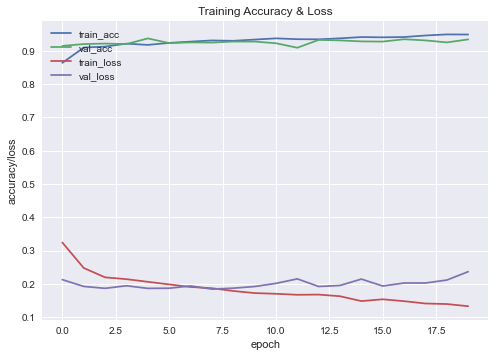

In [48]:
# history for training loss and accuracy
plt.style.use("seaborn")
plt.plot(history.history['accuracy'], label='train_acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend(loc='upper left')
plt.title('Training Accuracy & Loss')
plt.ylabel('accuracy/loss')
plt.xlabel('epoch')
plt.show()

In [85]:
# serialize model to JSON
model_json = classifier.to_json()
with open('model.json', 'w') as json_file:
    json_file.write(model_json)

In [84]:
# load json and create model
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
classifier = model_from_json(loaded_model_json)

In [81]:
# loading the best model
classifier.load_weights('neural_network.hdf5')

In [82]:
# evaluate the model
scores = classifier.evaluate(x_test, y_test3, verbose=0)
print("%s: %.2f%%" % (classifier.metrics_names[1], scores[1]*100))

accuracy: 93.90%
